# Load Libraries

In [1]:
# dl packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')

C:\Users\Hem Modi\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# Load dataset

In [2]:
train_data = pd.read_csv("train.txt", header = None, sep = ';', names = ['Comment', 'Emotion'], encoding = 'utf-8')

In [3]:
train_data

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
train_data.shape

(16000, 2)

In [5]:
#get length of all characters in comment
train_data['length'] = [len(x) for x in train_data['Comment']]


In [6]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [7]:
train_data.shape

(16000, 3)

In [8]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [9]:
train_data.duplicated().sum()

np.int64(1)

In [10]:
train_data.drop_duplicates(inplace = True)

# EDA

In [11]:
train_data['Emotion']

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15995    sadness
15996    sadness
15997        joy
15998      anger
15999    sadness
Name: Emotion, Length: 15999, dtype: object

In [12]:
train_data['Emotion'].value_counts()

Emotion
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

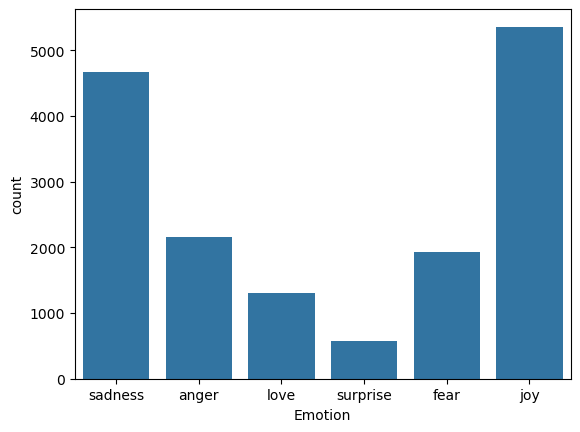

In [13]:
sns.countplot(x = train_data['Emotion'])
plt.show()

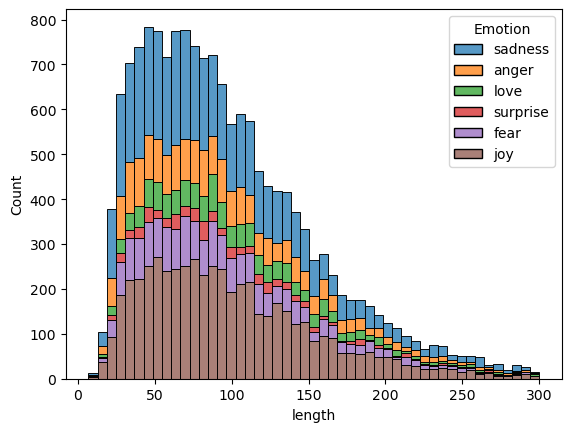

In [14]:
# data distribution
df2 = train_data.copy()

# convert the length column to a numpy array
length_values = df2['length'].values

#use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data = df2, x = 'length', hue = 'Emotion', multiple = 'stack')
plt.show()

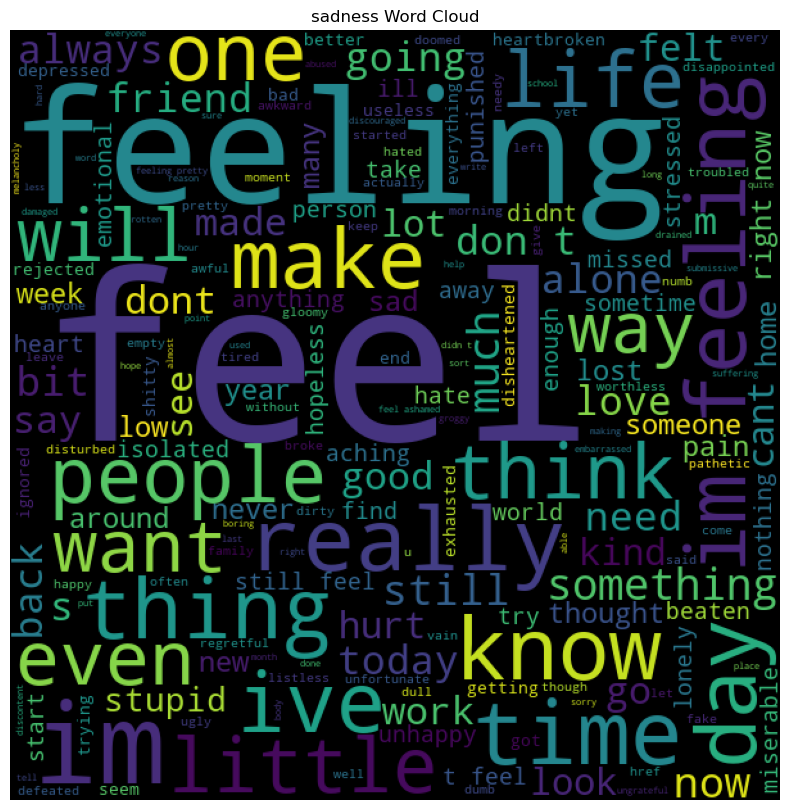

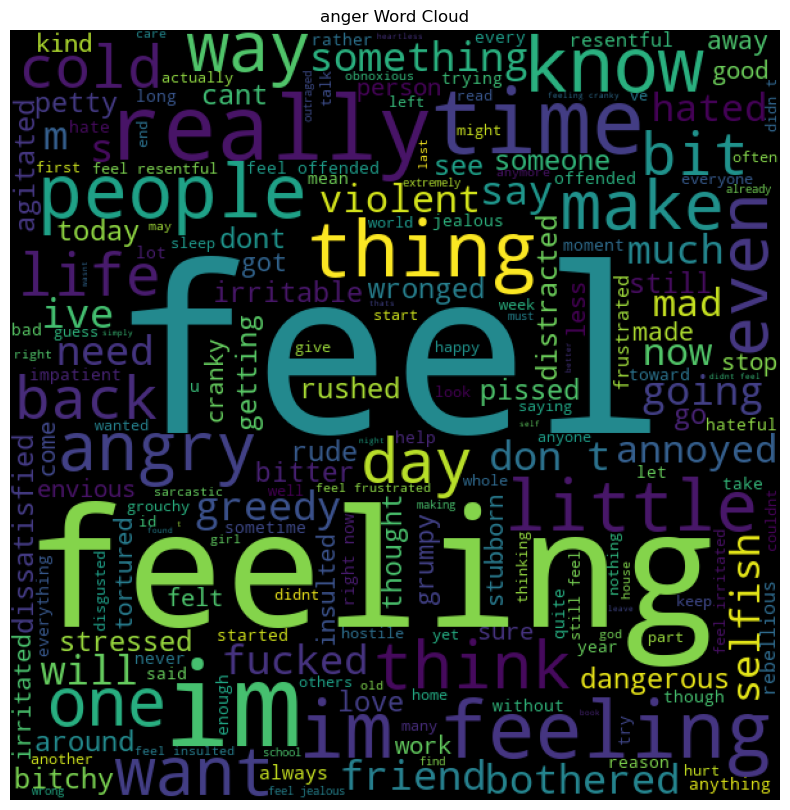

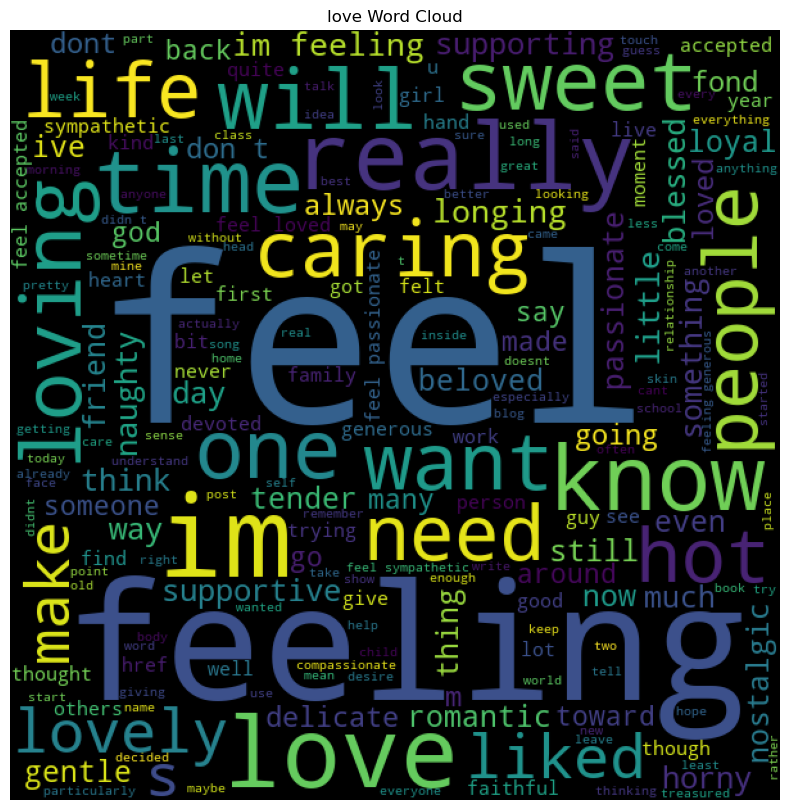

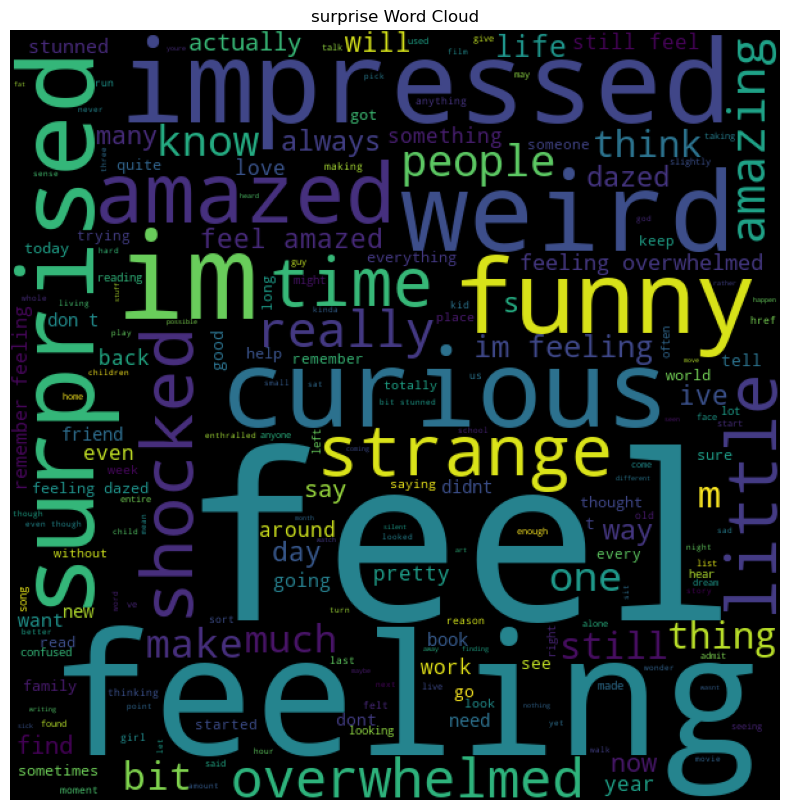

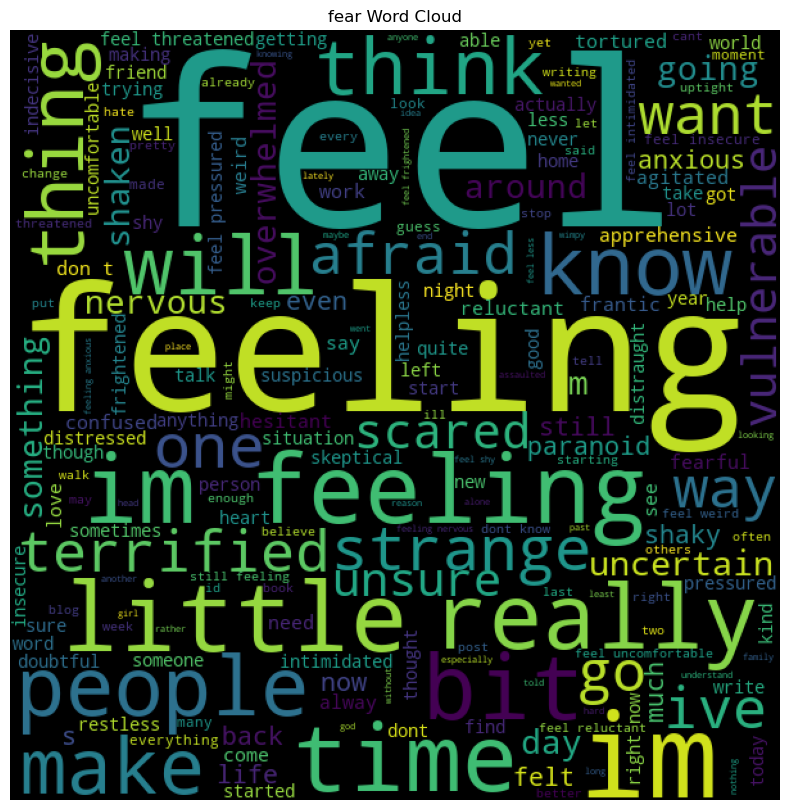

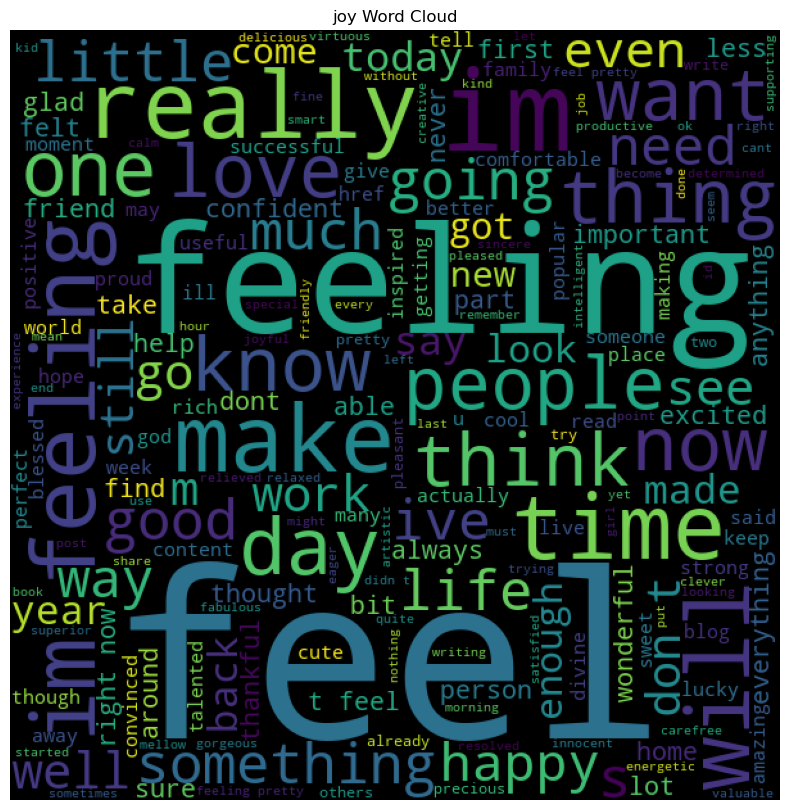

In [15]:
# words cloud for each emotions

def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10,10))
    plt.title(emotion + " " + "Word Cloud")
    plt.imshow(wordcloud)
    plt.axis("off")

emotions_list = train_data['Emotion'].unique() 

for emotion in emotions_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion, 'Comment']])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    words_cloud(wordcloud, emotion)

# Data preprocessing

# Encode emotions

In [16]:
le = LabelEncoder()
train_data['Emotion_encoded'] = le.fit_transform(train_data['Emotion'])

In [17]:
train_data

,Comment,Emotion,length,Emotion_encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


## Applying Machine Learning

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [19]:
df = train_data.copy()  # copy df from train_data because we will use this for deep learning next

In [20]:
df

,Comment,Emotion,length,Emotion_encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [21]:
# Data cleaning and preprocessing

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)
df['cleaned_comment'] = train_data['Comment'].apply(clean_text)

In [22]:
df

,Comment,Emotion,length,Emotion_encoded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,102,4,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,joy,30,2,feel strong good overal
15998,i feel like this was such a rude comment and i...,anger,59,0,feel like rude comment im glad


In [23]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion_encoded'], test_size = 0.2, random_state = 42)

In [24]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [25]:
# Multi-class classification using different algorithms
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\nAccuracy using TF-IDF: {accuracy_tfidf}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tfidf))


===== Multinomial Naive Bayes =====

Accuracy using TF-IDF: 0.6590625
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200


===== Logistic Regression =====

Accuracy using TF-IDF: 0.825
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.84      0.47      0.60       303
      

In [26]:
#selecting model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train) 
y_pred_lg = lg.predict(X_test_tfidf)

In [27]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = le.inverse_transform([predicted_label])[0]
    label =  np.max(lg.predict(input_vectorized))

    return predicted_emotion,label

# Example usage 
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


In [28]:
# save files
import pickle
pickle.dump(lg, open("logistic_regression.pkl", 'wb'))
pickle.dump(le, open("label_encoder.pkl", 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", 'wb'))

In [29]:
import sklearn
print(sklearn.__version__)

1.6.1


## Applying Deep learning Using LSTM

# Text Cleaning, Ecoding, and Padding

In [39]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
X_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

## Model Building and Training

In [40]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 400ms/step - accuracy: 0.4472 - loss: 1.4103
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 419ms/step - accuracy: 0.8260 - loss: 0.5167
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 417ms/step - accuracy: 0.9107 - loss: 0.2662
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 416ms/step - accuracy: 0.9404 - loss: 0.1813
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 414ms/step - accuracy: 0.9499 - loss: 0.1517
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 425ms/step - accuracy: 0.9563 - loss: 0.1244
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - accuracy: 0.9622 - loss: 0.1082 
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.9701 - loss: 0.0898
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.9747 - loss: 0.0729 
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.9767 - loss: 0.0667 


## Predictive System

In [42]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
joy : 0.9996451139450073


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
anger : 0.9985907673835754


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
joy : 0.45542362332344055


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
anger : 0.8278422355651855


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
sadness : 0.9972809553146362


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
love : 0.9784258008003235


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
joy : 0.

## Save the model and files

In [44]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

In [45]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

3.13.0
2.20.0
